In [1]:
%cd ..


/Users/eliaweiss/ai/segmentation/MobileSAM


In [2]:
import numpy as np
from TableDetect import TableDetect
from MobileSamBoxes import MobileSamBoxes
import matplotlib.pyplot as plt
from PIL import Image
import matplotlib.pyplot as plt

# colors for visualization
COLORS = [[0.000, 0.447, 0.741], [0.850, 0.325, 0.098], [0.929, 0.694, 0.125],
          [0.494, 0.184, 0.556], [0.466, 0.674, 0.188], [0.301, 0.745, 0.933]]

  
def plot_results(model, pil_img, prob, boxes):
    plt.figure(figsize=(16,10))
    plt.imshow(pil_img)
    ax = plt.gca()
    colors = COLORS * 100
    for p, (xmin, ymin, xmax, ymax), c in zip(prob, boxes.tolist(), colors):
        ax.add_patch(plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin,
                                fill=False, color=c, linewidth=3))
        cl = p.argmax().item()
        score = p[cl]
        text = f'{model.config.id2label[cl]}: {score:0.2f}'
        
        ax.text(xmin, ymin, text, fontsize=15,
                bbox=dict(facecolor='yellow', alpha=0.5))
    plt.axis('off')
    plt.show()
        
def show_anns(anns):
    if len(anns) == 0:
        return
    ax = plt.gca()
    ax.set_autoscale_on(False)
    img = np.ones((anns.shape[1], anns.shape[2], 4))
    img[:,:,3] = 0
    for ann in range(anns.shape[0]):
        m = anns[ann].bool()
        m=m.cpu().numpy()
        color_mask = np.concatenate([np.random.random(3), [1]])
        img[m] = color_mask
    ax.imshow(img)


def plot_annotations(anns):
    plt.figure(figsize=(10,10))
    background=np.ones_like(sam.image)*255
    plt.imshow(background)
    show_anns(anns)
    plt.axis('off')
    plt.show() 
    # plt.savefig("{}".format("./out/result.jpg"), bbox_inches='tight', pad_inches = 0.0)         


/Users/eliaweiss/ai/segmentation/MobileSAM/MobileSAMv2/tinyvit/tiny_vit.py:656: UserWarning: Overwriting tiny_vit_5m_224 in registry with tinyvit.tiny_vit.tiny_vit_5m_224. This is because the name being registered conflicts with an existing name. Please check if this is not expected.
  return register_model(fn_wrapper)
/Users/eliaweiss/ai/segmentation/MobileSAM/MobileSAMv2/tinyvit/tiny_vit.py:656: UserWarning: Overwriting tiny_vit_11m_224 in registry with tinyvit.tiny_vit.tiny_vit_11m_224. This is because the name being registered conflicts with an existing name. Please check if this is not expected.
  return register_model(fn_wrapper)
/Users/eliaweiss/ai/segmentation/MobileSAM/MobileSAMv2/tinyvit/tiny_vit.py:656: UserWarning: Overwriting tiny_vit_21m_224 in registry with tinyvit.tiny_vit.tiny_vit_21m_224. This is because the name being registered conflicts with an existing name. Please check if this is not expected.
  return register_model(fn_wrapper)
/Users/eliaweiss/ai/segmentation/

In [3]:
# file_path = "./app/assets/picture1.jpg"
file_path = "/Users/eliaweiss/Documents/doc2txt/sihach/attachments/img/20231025012642_001.jpg"
# file_path = "/Users/eliaweiss/Documents/doc2txt/invoices 2/expense (6).jpeg"

img = Image.open(file_path)
tblDec = TableDetect()
probas, boxes = tblDec.detectTables(img)



Some weights of the model checkpoint at microsoft/table-transformer-detection were not used when initializing TableTransformerForObjectDetection: ['model.backbone.conv_encoder.model.layer2.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer3.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer4.0.downsample.1.num_batches_tracked']
- This IS expected if you are initializing TableTransformerForObjectDetection from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TableTransformerForObjectDetection from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


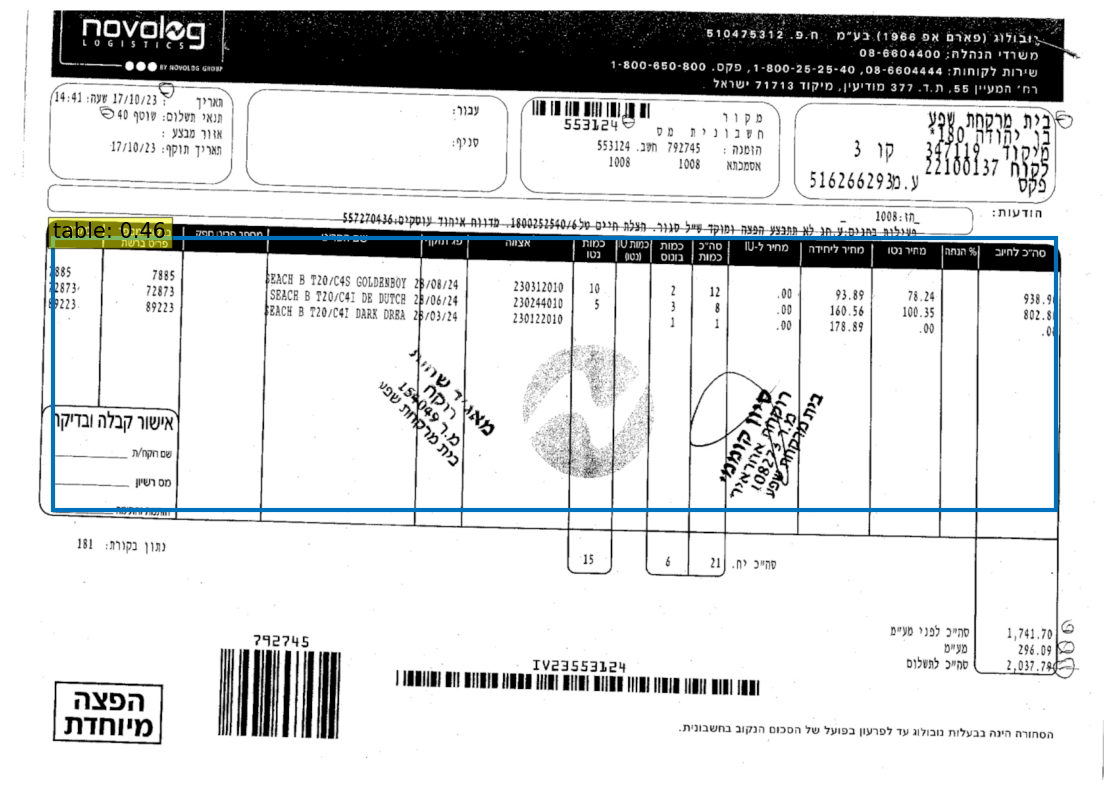

In [4]:
plot_results(tblDec.model, img, probas, boxes)


In [5]:
sam = MobileSamBoxes(img)
anns = sam.process(boxes)

checkpoint_load_scucess
shape (1201, 1706, 3)
------ total time: (s): 6.16


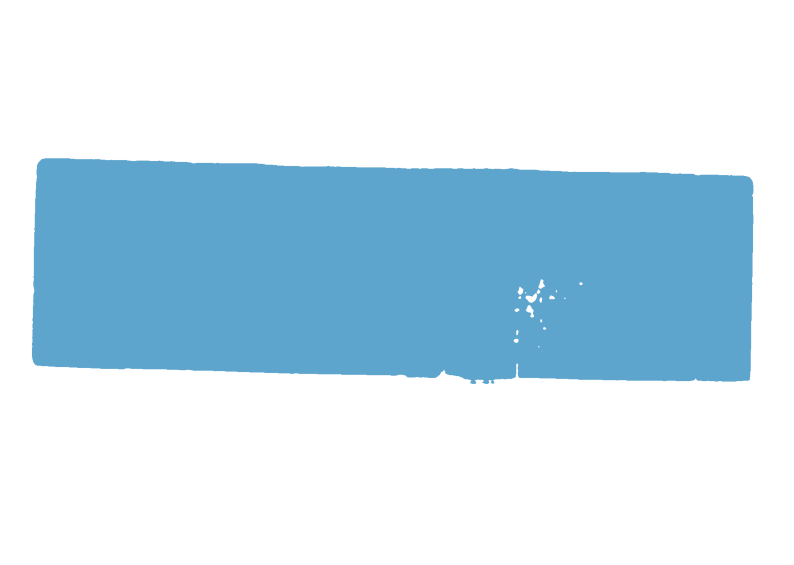

In [6]:
plot_annotations(anns)



In [8]:
from PIL import Image
import cv2

def create_mask_patch(image, mask):
  """
  Creates a patch from the image containing only the mask region.

  Args:
      image: A PIL image object.
      mask: A NumPy array representing the mask (1 for mask pixels).

  Returns:
      A PIL image object containing the patch from the original image 
      with only the mask region and white background for non-mask pixels.
  """
  mask=mask.cpu().numpy()
  mask = cv2.dilate(mask, np.ones((13, 13), np.uint8), iterations=1)  
  # Find non-zero elements (mask pixels) in the mask
  mask_coords = np.where(mask != 0)

  # Get minimum and maximum coordinates from the mask pixels
  min_y, min_x = mask_coords[0].min(), mask_coords[1].min()
  max_y, max_x = mask_coords[0].max() + 1, mask_coords[1].max() + 1  # Add 1 for inclusive range

  # Create the bounding box rectangle
  bounding_box = (min_x, min_y, max_x, max_y)


  mask = mask==1
  imgArr = np.array(image)
  imgArr[~mask] = (255,255,255)
  image = Image.fromarray(imgArr)
  # color_mask = np.concatenate([np.random.random(3), [1]])
  # img[m] = color_mask
  # Crop the image using the bounding box
  patch_image = image.crop(bounding_box)
  return patch_image

# Example usage
mask = anns[0]

patch = create_mask_patch(img, mask)
patch.show()  # Display the created patch
